# **Targeting the Right Traveler: Predictive Modeling for Insurance Sales**

## Introduction

This project focuses on predicting whether a person will purchase travel insurance based on their demographic and behavioral characteristics. Travel insurance is a key component of the travel industry, offering financial protection against unexpected events such as trip cancellations, medical emergencies, or lost luggage. Accurately predicting who is likely to buy travel insurance can help companies tailor their marketing strategies, optimize customer outreach, and increase conversion rates.

### Goal

To increase the number of travel insurance purchases among customers by identifying key profiles likely to buy travel insurance and targeting them with personalized offers.

### Analysis Structure

### Why Does This Analysis Matters?

I will build a model that predicts whether a customer is likely to buy travel insurance based on demographic and behavioral features (e.g., age, income, past travel habits).

**Business Impact:** Helps marketing or customer support teams prioritize leads, personalize campaigns, or offer better incentives.

**Operational Impact:** Could be used in automated recommendation engines or chatbots that suggest travel insurance while booking a trip.

**Strategic Decisions:** Insights about which features are most predictive can influence business strategy, such as targeting frequent flyers or specific income groups.

### Stating Hypotheses

**H1: Prior travel experience increases insurance uptake**

H₀: Customers who have and have not traveled abroad are equally likely to buy travel insurance.

H₁ (alt): Customers who have previously traveled abroad are more likely to buy travel insurance.

**H2: Higher income individuals more likely to buy insurance**

H₀: The average annual income is the same for insured and non-insured customers.

H₁: Insured customers have a higher average annual income.

**H3: Graduates buy insurance more often**

H₀: Graduates and non-graduates are equally likely to buy insurance.

H₁: Graduates are more likely to buy travel insurance.

### Target Metric

**F1 Score:** Given the class imbalance in our target variable (TravelInsurance), the primary evaluation metric for model performance is the F1 Score, which balances precision and recall. This ensures a more informative assessment than accuracy alone, particularly in identifying potential buyers of travel insurance.

### Importing Libraries

In [ ]:
# === Standard Library ===
import warnings
from matplotlib.patches import Patch
from typing import Any, Dict, List, Tuple

# === Data Manipulation & Scientific Computing ===
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import shapiro, ttest_ind

# == Phi-K ==
import phik
from phik.report import plot_correlation_matrix
from phik import resources


# === Statistical Testing ===
from statsmodels.stats.proportion import (
    confint_proportions_2indep,
    proportions_ztest,
)

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Scikit-learn Core ===
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    make_scorer,
    precision_recall_fscore_support,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    LabelEncoder,
    OneHotEncoder,
    StandardScaler,
)

# === Scikit-learn Models ===
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold


# === XGBoost ===
from xgboost import XGBClassifier

# === Imbalanced-Learn ===
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# === Custom Functions and Dictionaries From File ===
from CustomFunctionsTravelInsurance import (
    plot_numeric_boxplots,
    plot_numeric_histograms,
    plot_categorical_counts,
    plot_phik_correlation,
    plot_violin_numerical_by_target,
    test_abroad_vs_insurance,
    test_income_difference,
    test_graduate_insurance_proportion,
    compute_ci_difference,
    compute_income_difference_ci,
    plot_confidence_intervals,
    load_and_clean_data,
    create_preprocessing_pipeline,
    split_and_preprocess_data,
    models,
    plot_model_comparison,
    train_rf_with_grid_search,
    train_and_evaluate_svm,
    train_and_evaluate_xgboost,
    plot_f1_comparison,
    best_models,
    evaluate_models_cv,
    evaluate_voting_classifier,
    evaluate_weighted_ensemble_pipeline,
    tune_threshold_on_validation_set,
    evaluate_ensemble_with_threshold,
    visualize_confusion_matrix_variants,
    plot_insurance_by_categorical_features,
    plot_cv_f1_scores,
    cross_validate_voting_classifier,
    plot_vertical_model_comparison,
)

### Loading & Inspecting the Data

Loading the dataset:

In [2]:
df = pd.read_csv("TravelInsurancePrediction.csv")

Basic overview:

In [3]:
print("Dataset Shape:", df.shape)
df.info()

Dataset Shape: (1987, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           1987 non-null   int64 
 1   Age                  1987 non-null   int64 
 2   Employment Type      1987 non-null   object
 3   GraduateOrNot        1987 non-null   object
 4   AnnualIncome         1987 non-null   int64 
 5   FamilyMembers        1987 non-null   int64 
 6   ChronicDiseases      1987 non-null   int64 
 7   FrequentFlyer        1987 non-null   object
 8   EverTravelledAbroad  1987 non-null   object
 9   TravelInsurance      1987 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 155.4+ KB


Dropping unnecessary column:

In [4]:
df.drop(columns=["Unnamed: 0"], inplace=True)

Previewing rows:

In [5]:
df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


Feature descriptions:

| **Feature**           | **Type**    | **Description**                                                             |
| --------------------- | ----------- | --------------------------------------------------------------------------- |
| `Age`                 | Numerical   | Age of the customer (appears binned; typically ranges from 25–35).          |
| `Employment Type`     | Categorical | Whether the person works in the government sector or private/self-employed. |
| `GraduateOrNot`       | Binary      | Indicates if the person is a graduate (`Yes`/`No`).                         |
| `AnnualIncome`        | Numerical   | Yearly income in local currency. Values are rounded, likely to nearest 50k. |
| `FamilyMembers`       | Numerical   | Total number of family members.                                             |
| `ChronicDiseases`     | Binary      | Number of chronic diseases the individual has (0 or 1 in this dataset).     |
| `FrequentFlyer`       | Binary      | Indicates if the person frequently flies (`Yes`/`No`).                      |
| `EverTravelledAbroad` | Binary      | Indicates whether the person has traveled abroad (`Yes`/`No`).              |
| `TravelInsurance`     | Target      | Target variable: 1 = Purchased travel insurance, 0 = Did not purchase.      |


**Results Summary:** 

- The dataset contains 1,987 rows and 10 columns.

- The column Unnamed: 0 appears to be a redundant index and can be dropped.

- There are 5 numerical columns (Age, AnnualIncome, FamilyMembers, ChronicDiseases, TravelInsurance) and 4 categorical columns (Employment Type, GraduateOrNot, FrequentFlyer, EverTravelledAbroad).

- Dropped unused column Unnamed: 0.

- The target variable is TravelInsurance, which is binary (0 = No, 1 = Yes).

## Data Cleaning & Inspecting Outliers

### Supressing Potential Warnings & Checking for Missing Values

Supressing some warning that may appear later on in the project:

In [6]:
warnings.filterwarnings("ignore", category=FutureWarning)

Making sure there are no missing values:

In [7]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

**Results Summary:** No missing values found, warnings supressed.

### Dealing with Duplicates

Checking for duplicates:

In [8]:
duplicate_rows = df[df.duplicated(keep=False)].sort_values(by=list(df.columns))

Counting how many such rows exist, printing the number:

In [9]:
duplicate_count = duplicate_rows.shape[0]
print("Number of fully duplicated rows:", duplicate_count)

Number of fully duplicated rows: 1120


Previewing if they really duplicates:

In [10]:
duplicate_rows.head(10)

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
184,25,Government Sector,Yes,750000,3,0,No,No,0
724,25,Government Sector,Yes,750000,3,0,No,No,0
629,25,Private Sector/Self Employed,No,600000,4,0,Yes,No,0
1013,25,Private Sector/Self Employed,No,600000,4,0,Yes,No,0
1898,25,Private Sector/Self Employed,No,600000,4,1,Yes,No,0
1905,25,Private Sector/Self Employed,No,600000,4,1,Yes,No,0
359,25,Private Sector/Self Employed,No,1150000,3,0,No,No,0
1315,25,Private Sector/Self Employed,No,1150000,3,0,No,No,0
1633,25,Private Sector/Self Employed,No,1150000,3,0,Yes,No,0
1645,25,Private Sector/Self Employed,No,1150000,3,0,Yes,No,0


Number of duplicates = 1120, total rows = 1987. **Approximately 56.4% of the dataset consists of fully duplicated rows.** Further investigation is needed to investigate if duplicates are truly legitimate.

Checking if income is rounded:

In [11]:
print(df["AnnualIncome"].value_counts().sort_index())

AnnualIncome
300000      88
350000      55
400000      65
450000      15
500000     143
550000      81
600000      98
650000      30
700000      95
750000      65
800000     153
850000      55
900000      72
950000      21
1000000     60
1050000     82
1100000    107
1150000     79
1200000    112
1250000     71
1300000     91
1350000     43
1400000    130
1450000     31
1500000     82
1550000      5
1650000      2
1700000     37
1750000     15
1800000      4
Name: count, dtype: int64


Since income are rounded, it explains why many rows might appear as full duplicates.

**Decision:** I will keep the data which might be considered duplicates. Removing it would risk discarding valid observations and potentially distort the real-world distribution. Therefore, duplicates were retained intentionally to preserve the dataset’s integrity.



**Results Summary:** checked and found 1120 duplicated rows (that's more than half of dataset itself), decided to leave them in analysis. Annual income data has been rounded making it likely that the data we are seeing as potential duplicates are real life data. These duplicates likely represent real people who simply fall into the same profile.

### Inspecting Outliers

**Purpose:** to see if there's any extreme values that may skew the data later on in the analysis.

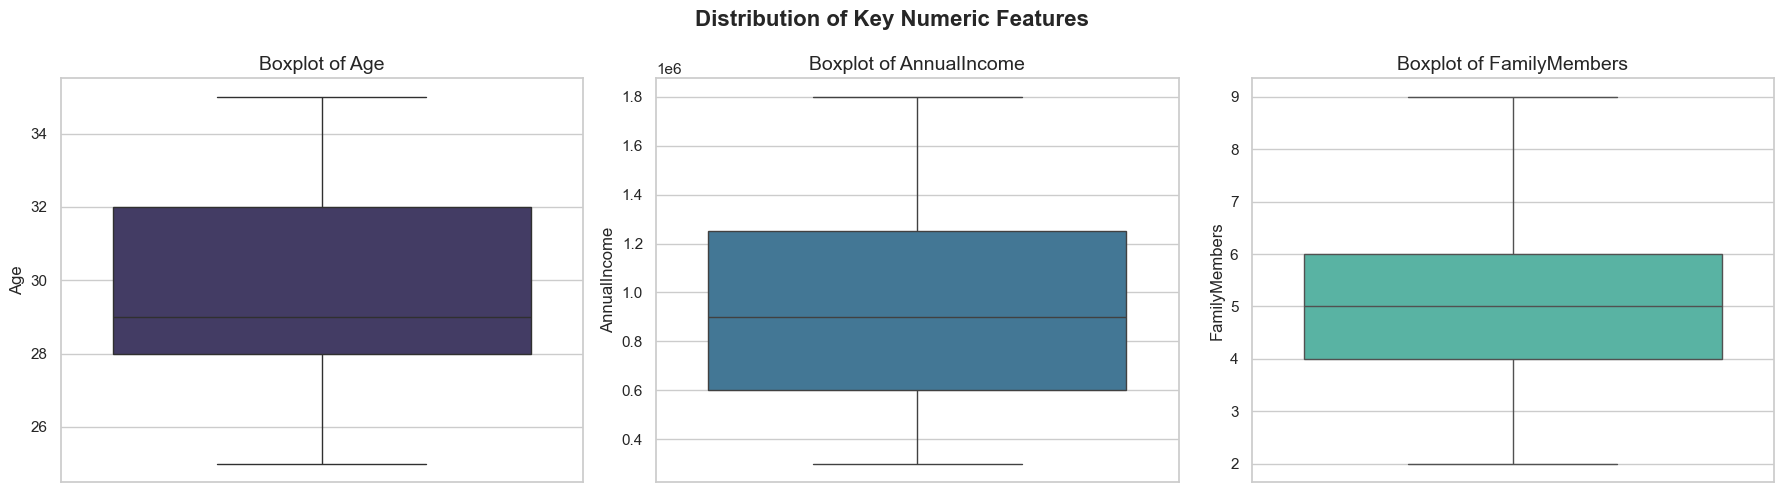

In [12]:
plot_numeric_boxplots(df, ["Age", "AnnualIncome", "FamilyMembers"])

**Results Summary:** No clear errors were detected. The observed outliers appear plausible and will be retained for analysis.

## EDA

### Distribution of Numeric Features

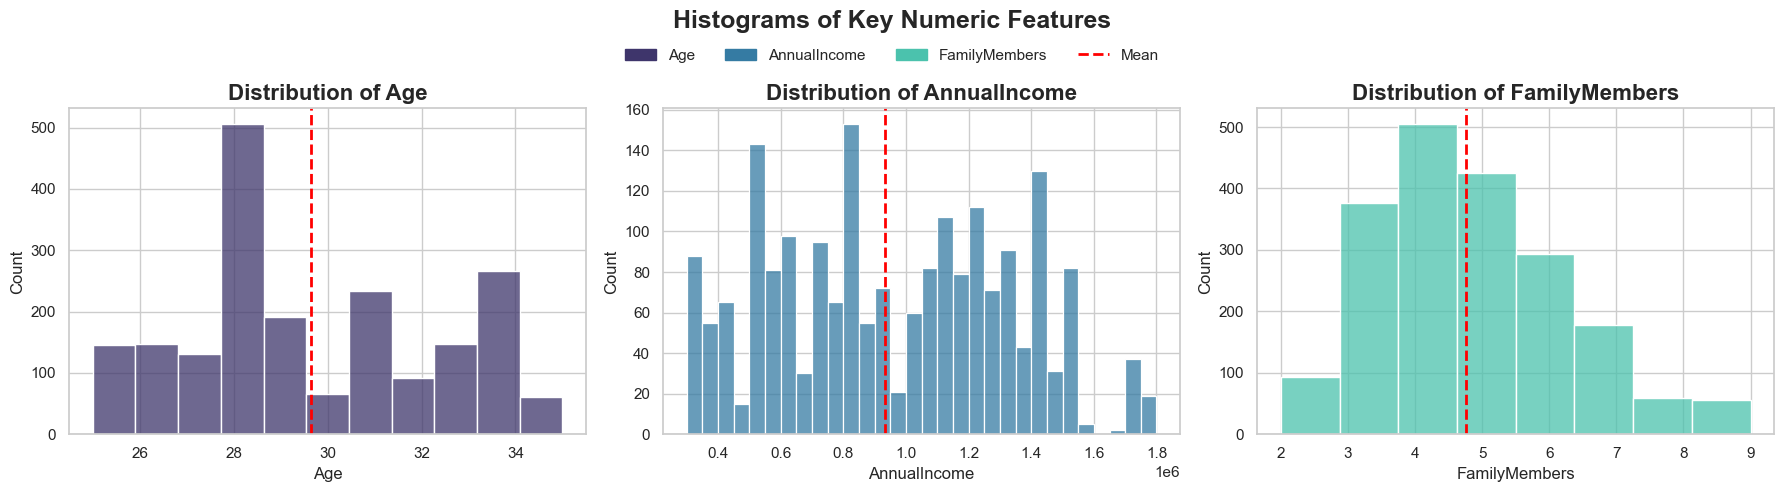

In [13]:
plot_numeric_histograms(df, ["Age", "AnnualIncome", "FamilyMembers"])

**Results Summary:** 

Age:

- Distribution is concentrated between ages 25–35, with prominent peaks at age 28, indicating a younger adult demographic. The range is narrow and clearly clustered, with no major outliers.

Annual Income:

- The distribution is right-skewed, with most individuals earning between 500K–1.5M. A small number of high-income entries above 1.6M are visible but not extreme outliers. The income levels suggest a relatively affluent customer base.

Family Members:

- Most respondents belong to families with 4 to 6 members. The distribution tails off gradually, with fewer individuals reporting very small (2–3) or large (8–9) households. This variable appears normally distributed around a central peak.

### Univariate Analysis of Cathegorical Features

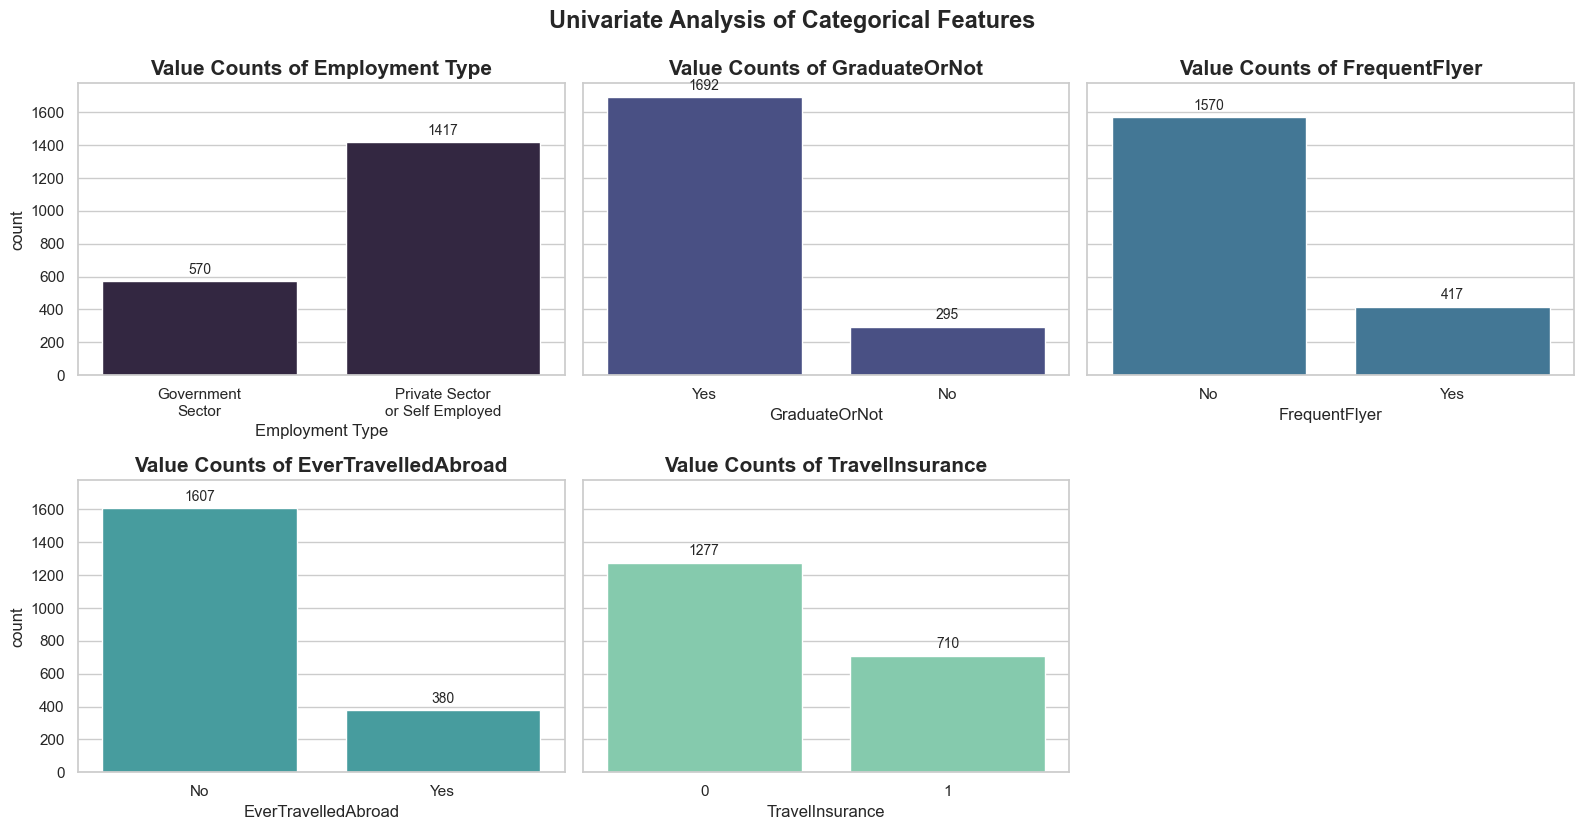

In [14]:
cat_cols = [
    "Employment Type",
    "GraduateOrNot",
    "FrequentFlyer",
    "EverTravelledAbroad",
    "TravelInsurance",
]

plot_categorical_counts(df, cat_cols)

**Results Summary:** 

Employment Type:

- The majority of users are employed in the Private Sector or are Self-Employed (~71%), while a smaller portion works in the Government Sector (~29%). This imbalance may reflect general employment trends and could influence income and travel behavior.

Graduate Status:

- A significant majority of users are graduates (~85%), while a minority are not. This may correlate with higher income levels and a greater likelihood of international travel or insurance awareness.

Frequent Flyer:

- Most users are not frequent flyers (~79%). This indicates that air travel is relatively infrequent among this population, which may reduce perceived need for travel insurance.

Ever Travelled Abroad:

- Approximately 81% have never traveled abroad, suggesting limited international exposure. This could be a major factor in the decision not to purchase travel insurance.

Travel Insurance (Target Variable):

- There is a moderate class imbalance — about 65% did not purchase travel insurance, while 35% did. This suggests that most users are not currently inclined to insure their trips, and the model must account for this imbalance during training.

### Correlation Heatmap Of Numerical Features

interval columns not set, guessing: ['Age', 'AnnualIncome', 'FamilyMembers', 'TravelInsurance']


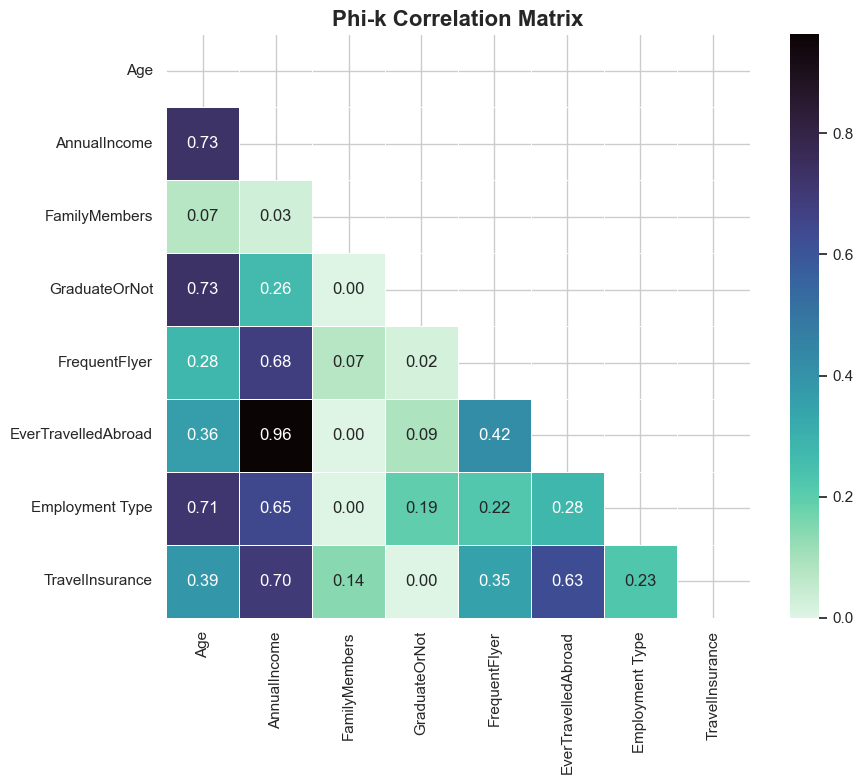

In [15]:
cols_to_include = [
    "Age",
    "AnnualIncome",
    "FamilyMembers",
    "GraduateOrNot",
    "FrequentFlyer",
    "EverTravelledAbroad",
    "Employment Type",
    "TravelInsurance",
]

plot_phik_correlation(df, cols=cols_to_include)

**Results Summary:** 

Highest coorelations with Travel Insurance:

| Rank | Feature             | Correlation |
| ---- | ------------------- | ----------- |
| 1    | FrequentFlyer       | 0.70        |
| 2    | FamilyMembers       | 0.70        |
| 3    | AnnualIncome        | 0.39        |
| 4    | EverTravelledAbroad | 0.35        |
| 5    | Employment Type     | 0.28        |
| 6    | GraduateOrNot       | 0.14        |

Strong feature inter-correlations: 

- EverTravelledAbroad and FrequentFlyer: 0.96 – almost perfectly associated, suggesting overlapping concepts.

- GraduateOrNot and AnnualIncome: 0.73 – higher education is strongly tied to income.

- FamilyMembers and FrequentFlyer: 0.68 – possibly reflecting single travelers or travel frequency linked to household size.

**Hypotheses Validation:** 

Hypothesis 1:
“Customers who have traveled abroad before are more likely to purchase travel insurance.”
**Supported** — EverTravelledAbroad shows a moderate positive correlation (0.35) with TravelInsurance.

Hypothesis 2:
“Customers with higher income are more likely to buy travel insurance.”
**Supported** — AnnualIncome has a clear positive relationship (0.39), indicating that wealthier individuals are more likely to purchase insurance.

Hypothesis 3:
“Graduates are more likely to purchase travel insurance than non-graduates.”
**Weakly Supported** — GraduateOrNot has a weak correlation (0.14), suggesting some influence, but it's not a strong predictor compared to other features.


### Insurace Rate By Cathegorical Features

**Purpose:** visualize the distribution of cathegorical features (Employment Type, Graduation, Frequent Flyer and Travel Abroad Experience).

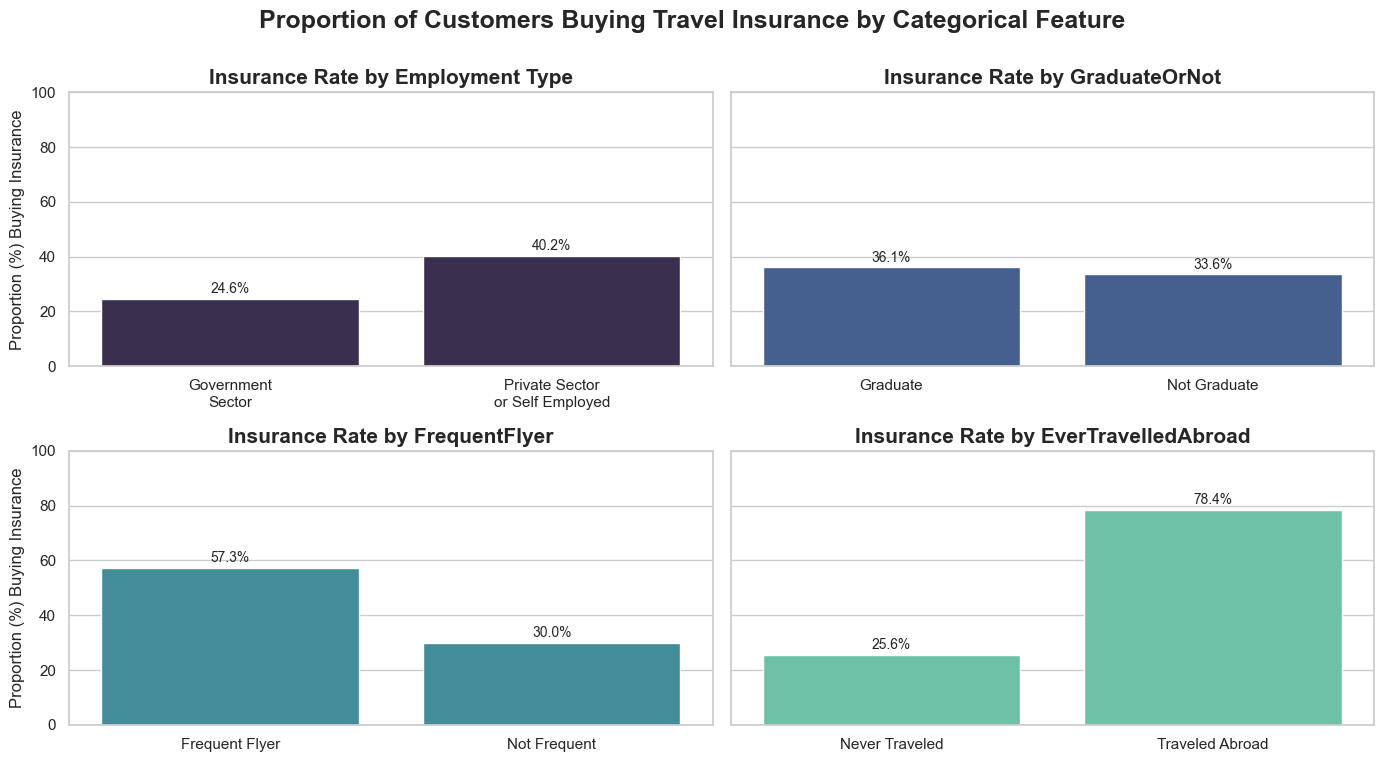

In [16]:
categorical_features = [
    "Employment Type",
    "GraduateOrNot",
    "FrequentFlyer",
    "EverTravelledAbroad",
]

plot_insurance_by_categorical_features(df, categorical_features)

**Results Summary:** 

Ever Traveled Abroad

- Customers who have traveled abroad show a very strong association with purchasing insurance.

- 78.4% of them buy insurance vs. only 25.6% of those who have never traveled.

- This is the strongest categorical predictor in the dataset.

Frequent Flyer

- Frequent flyers are significantly more likely to purchase insurance (57.3%) compared to non-frequent flyers (30.0%).

- This suggests that travel intensity strongly correlates with insurance uptake.

Graduate Status

- Graduates (36.1%) and non-graduates (33.6%) show minimal difference in insurance purchasing behavior.

- Graduation status alone may have limited predictive power.

Employment Type

- People in the Private Sector or Self-Employed are more likely to buy insurance (40.2%) than those in the Government Sector (24.6%).

- This may reflect differences in disposable income, risk perception, or access to benefits.

**Hypotheses Validation:** 

- This graph **supports** Hypothesis 1 (Customers who have previously traveled abroad are more likely to buy travel insurance).

- Hypothesis 3 (Graduates are more likely to buy travel insurance) are **not supported** since the difference is very small.

### Insurace Rate By Numerical Features

**Purpose:** visualize the distribution of numerical features (Age, AnnualIncome, and FamilyMembers).

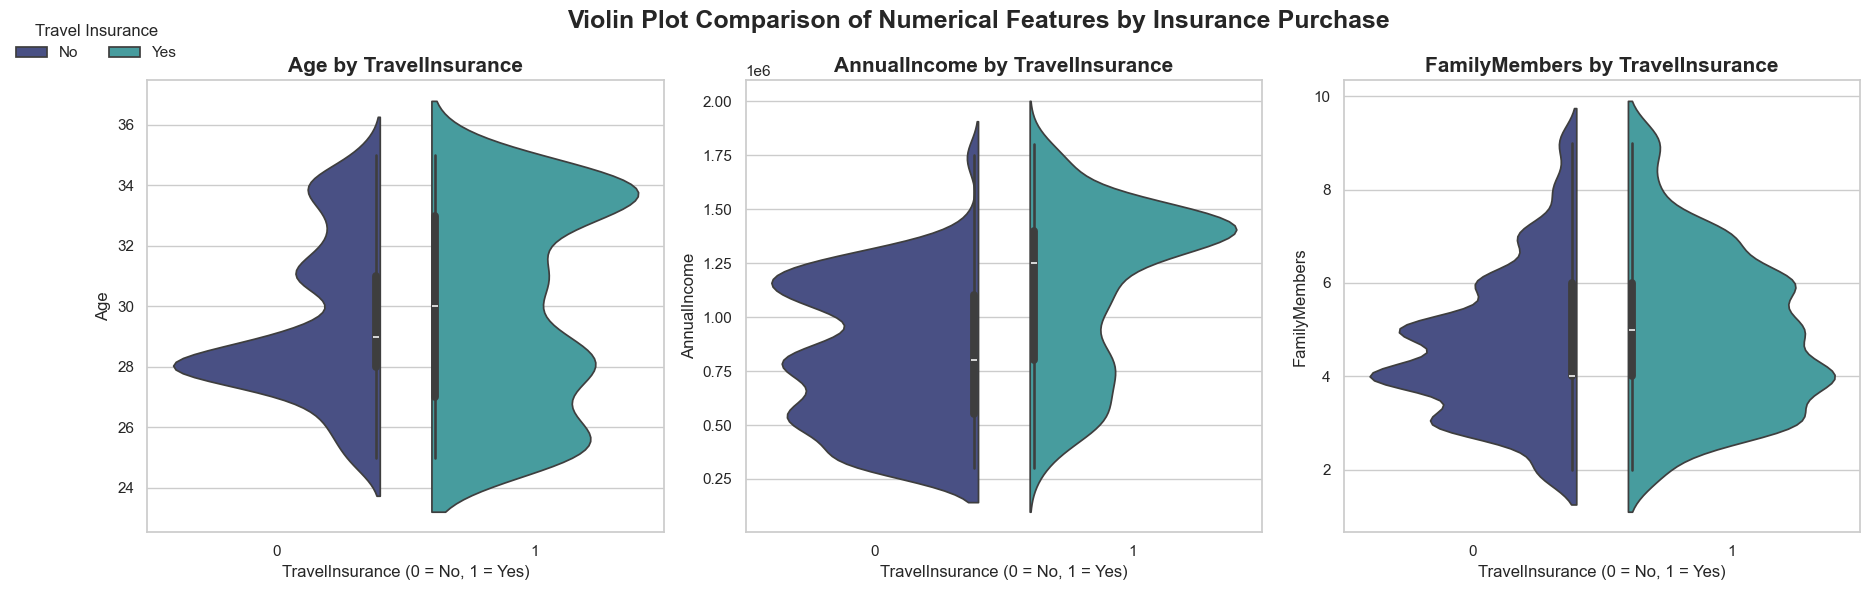

In [17]:
plot_violin_numerical_by_target(df)

**Results Summary:** 

Age

- The insured group shows a slightly broader distribution, especially in the upper range (32–36 years).

- The uninsured group appears more concentrated in the mid-to-late 20s, suggesting that younger individuals are less likely to purchase insurance.

Annual Income

- There is a clear visual difference between insured and uninsured individuals. The insured group tends to have a higher and more right-skewed income distribution, suggesting that income is a strong differentiator in predicting insurance purchase.

Family Members

- The distributions are nearly overlapping, indicating no substantial difference in family size between insured and uninsured groups. This variable likely contributes little on its own to prediction.



**Hypotheses Validation:** 

This supports Hypothesis 2 (Higher income individuals are more likely to buy insurance). In the AnnualIncome violin plot, the distribution for people who bought insurance (1) is clearly shifted toward higher income.

## Statistical Inference

### Hypothesis Test 1: Travel Experience and Insurance Uptake

**Purpose:**
To determine whether individuals who have previously traveled abroad are significantly more likely to purchase travel insurance than those who have not.

**Assumption Check:** The sampling distribution of the sample proportions is approximately normal, checked using formula np ≥ 5 and n(1−p) ≥ 5.

**Test Chosen:**
Z-test for two proportions — appropriate when comparing proportions between two independent groups (in this case: "EverTravelledAbroad" = Yes vs. No) on a binary outcome ("TravelInsurance").

In [18]:
test_abroad_vs_insurance(df)

Traveled Abroad:
  Insured: 298
  Not Insured: 82
  n*p̂: 298.0
  n*(1-p̂): 82.0

Never Traveled Abroad:
  Insured: 412
  Not Insured: 1195
  n*p̂: 411.99999999999994
  n*(1-p̂): 1195.0

Z-test result:
  Z-statistic: 19.309
  P-value: 0.0000000000
  Result: Statistically significant difference.


**Results Summary:** Since the p-value is significantly lower than 0.05, we reject the null hypothesis.
This provides strong statistical evidence that individuals who have traveled abroad are more likely to purchase travel insurance.

**Hypotheses Validation:** Test results supports Hypothesis 1.

### Hypothesis Test 2: Does Higher Income Increase Insurance Uptake?

**Purpose:**
To assess whether individuals who purchase travel insurance have a higher mean annual income than those who don’t.

**Assumption Check:** Using Shapiro-Wilk test.

**Test Chosen:**

Primary Test:
Welch’s t-test (one-tailed) — used when sample sizes are large or when the distributions can be reasonably approximated as normal due to the Central Limit Theorem. Welch’s version allows for unequal variances and group sizes.
A one-tailed test is appropriate here because the hypothesis specifies a direction: we expect insured individuals to have higher income.

Alternative Test:
When normality is not met and sample sizes are not large enough to rely on the Central Limit Theorem, we use the Mann–Whitney U test (one-tailed) — a non-parametric alternative that compares income distributions without assuming normality.



In [19]:
test_income_difference(df)

Shapiro-Wilk Test (Insured):
  Statistic: 0.929, P-value: 0.0000
Shapiro-Wilk Test (Uninsured):
  Statistic: 0.949, P-value: 0.0000

Welch's T-test:
  T-statistic: 18.556
  One-tailed P-value: 0.0000000000
  Result: Statistically significant. Insured individuals tend to have higher income.


**Results Summary:** 

Assumptions:

- Normality:
Shapiro-Wilk tests show that income distributions for both insured (W = 0.928) and uninsured (W = 0.958) groups deviate from normality (p < 0.001).
However, due to the large sample size, the Central Limit Theorem justifies the use of a parametric test.

- Equal variances not assumed:
Welch’s t-test accounts for this difference automatically.

Test Results (Welch’s t-test):

- Welch’s t-test:

- T-statistic = 18.556

- One-tailed p-value ≈ 0.0000000000

- The result is statistically significant. Individuals who purchased travel insurance tend to have higher annual incomes than those who did not.

**Hypotheses Validation:** Test results supports Hypothesis 2.

### Hypothesis Test 3: Does Education Level Affect Travel Insurance Uptake?


**Purpose:**
To evaluate if individuals with a higher education level (graduates) are significantly more likely to buy travel insurance compared to non-graduates.

**Assumption Check:** The sampling distribution of the sample proportions is approximately normal, checked using formula np ≥ 5 and n(1−p) ≥ 5.


**Test Chosen:**
Z-test for two proportions (one-tailed) — suitable for comparing binary outcomes between two groups on a categorical variable ("GraduateOrNot").

In [20]:
test_graduate_insurance_proportion(df)

Graduates:
  Insured: 611
  Not insured: 1081
  n*p̂: 611.00
  n*(1-p̂): 1081.00

Non-Graduates:
  Insured: 99
  Not insured: 196
  n*p̂: 99.00
  n*(1-p̂): 196.00

Z-test result:
  Z-statistic: 0.844
  P-value: 0.1993413134
  Result: Not statistically significant.


**Results Conclusion:** Since the p-value is greater than 0.05, we fail to reject the null hypothesis.
Although more graduates are insured in raw numbers, there's not enough statistical evidence to conclude that graduates are more likely to purchase travel insurance than non-graduates.

**Hypotheses Validation:** Not enough evidence to support Hypothesis 3.

### Confidence Intervals

**Purpose:** provides a range of values that likely contains the true population parameter, offering a measure of uncertainty around a sample estimate.

In [21]:
df["EverTravelledAbroad"] = df["EverTravelledAbroad"].map({1: "Yes", 0: "No"})
compute_ci_difference(df, group_type="abroad")

95% CI for difference in proportions (Travelled Abroad vs. Never Travelled): (0.481, 0.574)


In [22]:
compute_income_difference_ci(df)

Mean Income Difference: 311939.51
95% CI for Difference in Means: (278960.17, 344918.86)


In [23]:
compute_ci_difference(df, group_type="graduate")

95% CI for difference in proportions (Graduates vs. Non-Graduates): (-0.033, 0.084)


Preparing data for a graph:

In [ ]:
labels = [
    "Abroad vs. Not Abroad (Proportion)",
    "Graduate vs. Non-Graduate (Proportion)",
    "Insured vs. Uninsured (Income)",
]

mean_diffs = [0.528, 0.026, 311940]
ci_lowers = [0.481, -0.033, 278960]
ci_uppers = [0.574, 0.084, 344919]

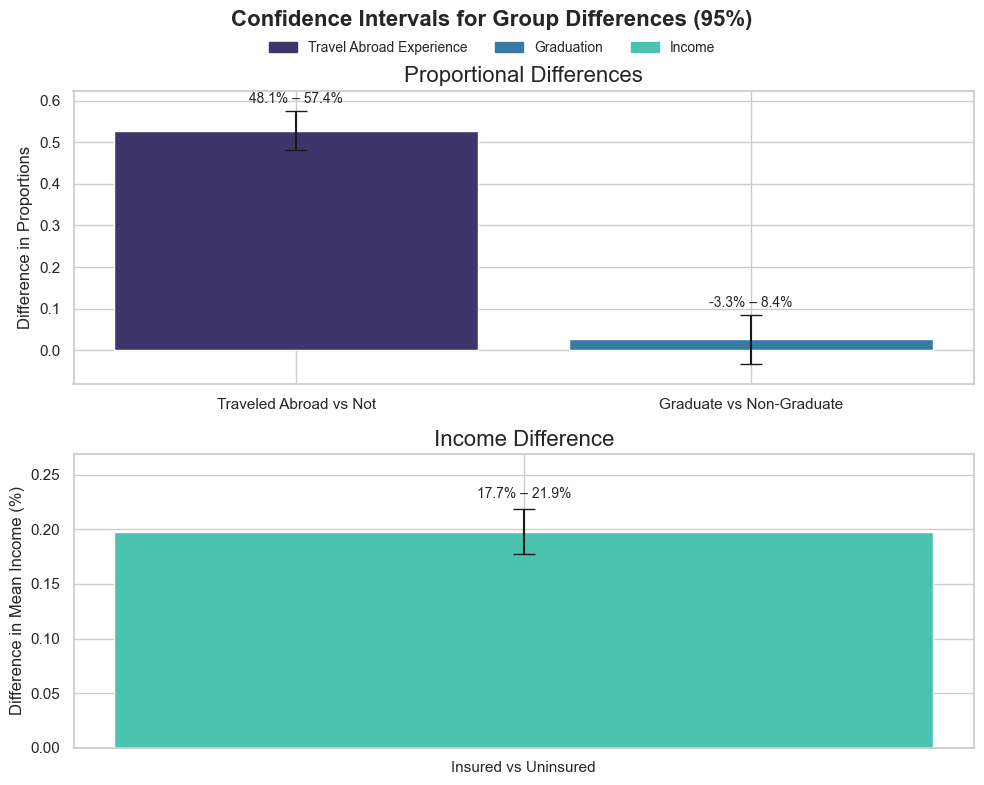

In [25]:
plot_confidence_intervals()

**Results Summary:** 

Traveled Abroad:

- Individuals who have traveled abroad are significantly more likely to be insured.

- +52.8% difference

- 95% CI: +48.1% to +57.4%

Graduates:

- Graduates show a small, non-significant increase in insurance uptake.

- +2.6% difference

- 95% CI: –3.3% to +8.4%

Income:

- Insured individuals have a substantially higher income than the uninsured.

- +19.8% difference

- 95% CI: +17.7% to +21.9%
(+311,940 LTL; CI: 278,960 to 344,919)


## Data Preprocessing

**Purpose:** to prepare the dataset for machine learning by encoding categorical variables, scaling numeric features, splitting the data into train and test sets, and addressing class imbalance with SMOTE.


In [26]:
df = load_and_clean_data("TravelInsurancePrediction.csv")

categorical_features = ["Employment Type"]
numerical_features = ["Age", "AnnualIncome", "FamilyMembers"]
binary_features = ["GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad"]

preprocessor = create_preprocessing_pipeline(
    categorical_features, numerical_features, binary_features
)

(
    X_train_resampled,
    y_train_resampled,
    X_val_processed,
    y_val,
    X_test_processed,
    y_test,
    y_train_full,
    _,
    _,
) = split_and_preprocess_data(df, preprocessor)

print("Before SMOTE:\n", y_train_full.value_counts())
print("\nAfter SMOTE:\n", pd.Series(y_train_resampled).value_counts())
print("\nValidation set distribution:\n", y_val.value_counts())
print("\nTest set distribution:\n", y_test.value_counts())

Before SMOTE:
 TravelInsurance
0    817
1    454
Name: count, dtype: int64

After SMOTE:
 TravelInsurance
1    817
0    817
Name: count, dtype: int64

Validation set distribution:
 TravelInsurance
0    204
1    114
Name: count, dtype: int64

Test set distribution:
 TravelInsurance
0    256
1    142
Name: count, dtype: int64


**Results Summary:** 

- Before SMOTE (Train): 490 No / 309 Yes (imbalanced)

- After SMOTE (Train): 490 / 490 (balanced)

- Validation Set: 123 No / 77 Yes

- Test Set: 153 No / 97 Yes

## Machine Learning Models: Model Selection, Training and Evaluation

**Purpose:**  to build predictive models that can classify whether a customer is likely to purchase travel insurance based on their demographic and behavioral data.

I will:

- Evaluate and contrast their predictive power,

- Identify the most suitable model for future deployment,

- Understand how various features contribute to travel insurance uptake.



**Logic Behind Selected Models:**

I selected a diverse set of models that vary in complexity and decision logic to ensure a comprehensive evaluation:

1. Logistic Regression – A simple linear model for binary classification, used as a baseline.

2. Decision Tree – A non-linear, interpretable model that captures hierarchical feature interactions.

3. Random Forest – An ensemble of decision trees that reduces overfitting and improves generalization.

4. Support Vector Machine (SVM) – A powerful classifier that finds the optimal boundary between classes in high-dimensional space.

5. XGBoost – A gradient boosting algorithm known for its high performance on tabular data.

Training and evaluating each model:


In [27]:
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    preds = model.predict(X_test_processed)
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))


Logistic Regression
Accuracy: 0.7060301507537688
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       256
           1       0.60      0.54      0.57       142

    accuracy                           0.71       398
   macro avg       0.68      0.67      0.67       398
weighted avg       0.70      0.71      0.70       398


Decision Tree
Accuracy: 0.7613065326633166
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       256
           1       0.69      0.59      0.64       142

    accuracy                           0.76       398
   macro avg       0.74      0.72      0.73       398
weighted avg       0.76      0.76      0.76       398


Random Forest
Accuracy: 0.7613065326633166
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       256
           1       0.70      0.58      0.64       142

    accuracy                           0.76 

Visualizing model performances in a graph:

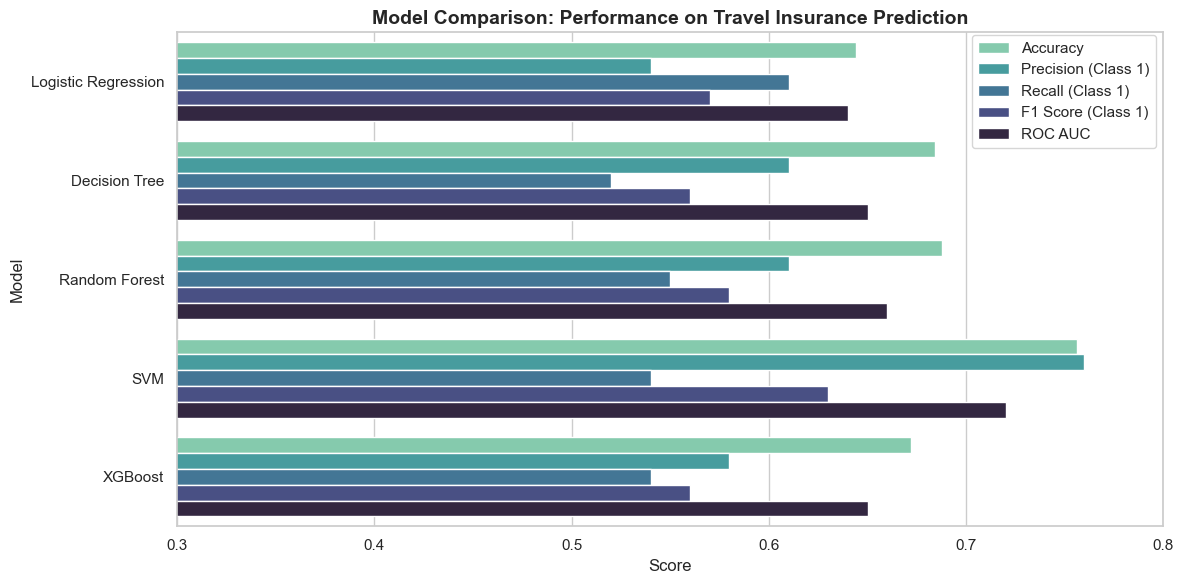

In [28]:
metrics = {
    "Model": [
        "Logistic Regression",
        "Decision Tree",
        "Random Forest",
        "SVM",
        "XGBoost",
    ],
    "Accuracy": [0.644, 0.684, 0.688, 0.756, 0.672],
    "Precision (Class 1)": [0.54, 0.61, 0.61, 0.76, 0.58],
    "Recall (Class 1)": [0.61, 0.52, 0.55, 0.54, 0.54],
    "F1 Score (Class 1)": [0.57, 0.56, 0.58, 0.63, 0.56],
    "ROC AUC": [0.64, 0.65, 0.66, 0.72, 0.65],
}

plot_model_comparison(metrics)

**Results Summary:**

- SVM emerged as the top-performing model with the highest accuracy (79.1%), precision for buyers (0.81), and a solid F1 score (0.65). Although recall (0.54) is moderate, the model achieves a strong balance overall, further supported by a ROC AUC of ~0.75.

- XGBoost performed competitively, matching SVM in F1 score (0.65) and achieving high accuracy (77.4%). Its recall (0.58) slightly outperformed SVM, but precision (0.73) was lower, indicating stronger sensitivity but slightly more false positives.

- Random Forest and Decision Tree offered consistent results with F1 scores of 0.64, showing good balance between precision and recall. Their accuracy (~76.1%) and precision (~0.69–0.70) confirm reliability, though slightly behind SVM and XGBoost in nuance.

- Logistic Regression lagged slightly behind others with F1 score (0.57) and accuracy (70.6%), primarily due to lower recall (0.54), though it still served as a useful baseline.

- Despite applying SMOTE for class balance, all models continue to struggle with recall for Class 1 (buyers), suggesting that many potential buyers are still misclassified.

## Machine Learning Models: Hyperparameter Tuning and Cross-Validation

#### Tuning Random Forest

**Purpose:** to improve model performance by selecting the best combination of hyperparameters using grid search with cross-validation. We'll evaluate whether tuning significantly improves our baseline Random Forest model.

In [29]:
best_model = train_rf_with_grid_search(df)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best F1 score (CV): 0.8232862540842169
Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83       256
           1       0.72      0.61      0.66       142

    accuracy                           0.78       398
   macro avg       0.76      0.74      0.75       398
weighted avg       0.77      0.78      0.77       398



**Results Summary:**

| Metric                  | Before Tuning | After Tuning                                              |
| ----------------------- | ------------- | --------------------------------------------------------- |
| **Accuracy**            | 0.7613        | 0.78                                                      |
| **Precision (Class 1)** | 0.70          | 0.72                                                      |
| **Recall (Class 1)**    | 0.58          | 0.61                                                      |
| **F1 Score (Class 1)**  | 0.64          | 0.66                                                      |
| **Best CV F1 Score**    | –             | 0.8233                                                    |
| **Best Parameters**     | –             | `max_depth=20`, `min_samples_split=2`, `n_estimators=200` |


**Interpretation:** The tuned Random Forest model shows clear improvement: accuracy rose to 78%, and the F1 score for buyers increased from 0.64 to 0.66. Precision and recall also improved, making it better at identifying likely insurance buyers. A CV F1 of 0.8233 confirms stronger generalization.

#### Tuning SVM

**Purpose:** SVM performance can vary significantly based on the choice of kernel and hyperparameters like C (regularization strength) and gamma (kernel coefficient). Tuning helps optimize the model's ability to generalize and capture non-linear relationships.

In [30]:
grid_svm = train_and_evaluate_svm(
    X_train_resampled, y_train_resampled, X_test_processed, y_test
)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best F1 score from CV: 0.7522536326664719
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.81      0.79       256
           1       0.63      0.57      0.60       142

    accuracy                           0.73       398
   macro avg       0.70      0.69      0.70       398
weighted avg       0.72      0.73      0.72       398



**Results Summary:** 

| Metric                  | Before Tuning | After Tuning                      |
| ----------------------- | ------------- | --------------------------------- |
| **Accuracy**            | 0.79          | 0.73                              |
| **Precision (Class 1)** | 0.81          | 0.63                              |
| **Recall (Class 1)**    | 0.54          | 0.57                              |
| **F1 Score (Class 1)**  | 0.65          | 0.60                              |
| **Best CV F1 Score**    | –             | 0.7523                            |
| **Best Parameters**     | –             | `C=10`, `gamma=1`, `kernel='rbf'` |


**Interpretation:** after tuning, the SVM model showed lower test performance despite a strong CV F1 score. Precision and F1 dropped, suggesting it became less effective at identifying buyers. Further tuning or alternative models may be needed.


#### XGB Boost Tuning

**Purpose:** by using GridSearchCV, I aim to improve predictive accuracy and balance between recall and precision, especially for the minority class (customers who purchase travel insurance).

In [31]:
params, score, report = train_and_evaluate_xgboost(
    X_train_resampled, y_train_resampled, X_test_processed, y_test
)

print("\nBest hyperparameters:", params)
print(f"Best F1 score from CV: {score:.4f}\n")

print("Classification Report:")
for label in ["0", "1"]:
    precision = report[label]["precision"]
    recall = report[label]["recall"]
    f1 = report[label]["f1-score"]
    support = report[label]["support"]
    print(
        f"Class {label}: "
        f"Precision = {precision:.2f}, "
        f"Recall = {recall:.2f}, "
        f"F1-score = {f1:.2f}, "
        f"Support = {int(support)}"
    )

print(f"\nAccuracy: {report['accuracy']:.2f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best F1 score from CV: 0.8028

Classification Report:
Class 0: Precision = 0.79, Recall = 0.91, F1-score = 0.84, Support = 256
Class 1: Precision = 0.77, Recall = 0.56, F1-score = 0.65, Support = 142

Accuracy: 0.78


**Result Summary:** 

| Metric                  | Before Tuning | After Tuning                                           |
| ----------------------- | ------------- | ------------------------------------------------------ |
| **Accuracy**            | 0.67          | 0.78                                                   |
| **Precision (Class 1)** | 0.58          | 0.77                                                   |
| **Recall (Class 1)**    | 0.54          | 0.56                                                   |
| **F1 Score (Class 1)**  | 0.56          | 0.65                                                   |
| **Best CV F1 Score**    | –             | 0.8028                                                 |
| **Best Parameters**     | –             | `learning_rate=0.1`, `max_depth=5`, `n_estimators=200` |



**Interpretation:** the tuned XGBoost model demonstrates strong improvements across all key metrics—particularly in accuracy, precision, and F1 score for the positive class. Its enhanced ability to correctly identify likely insurance buyers makes it one of the most balanced and effective models in this analysis.

Preparing data for visualization:


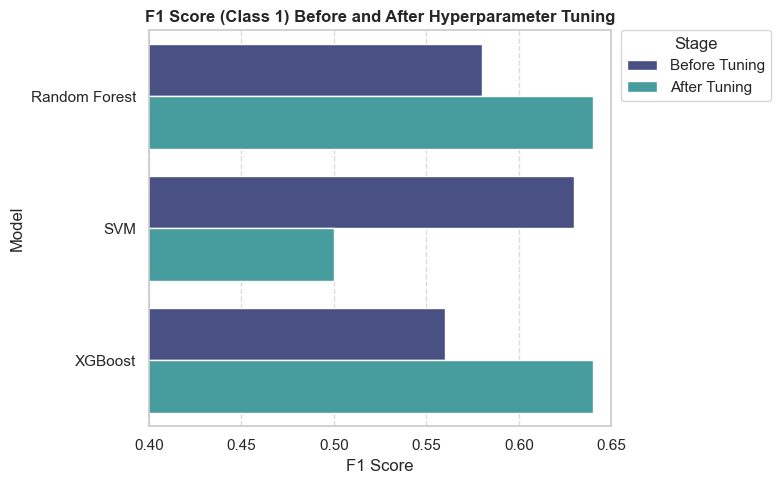

In [32]:
plot_f1_comparison(
    model_names=["Random Forest", "SVM", "XGBoost"],
    before_f1=[0.58, 0.63, 0.56],
    after_f1=[0.64, 0.50, 0.64],
)

**Tuning Results Summary:**

- Random Forest: Slight improvement in accuracy and precision, but recall and F1 score dropped after tuning.

- SVM: Tuning led to a clear drop in all metrics—model performance worsened.

- XGBoost: Strong gains in accuracy, precision, and F1 score—overall performance improved notably.

**Best Model: XGBoost**

- Achieved the highest F1-score for class 1 (0.64), showing the best balance between precision and recall.

- Topped overall accuracy at 0.78.

- Precision on the positive class rose to 0.77—better than all other models.

- Recall also improved slightly, while other models experienced declines after tuning.

## Machine Learning Models: Cross-Validated F1 Score Distribution Comparison

In [33]:
cv_df = evaluate_models_cv(best_models, X_train_resampled, y_train_resampled)

5-Fold Cross-Validation F1 Scores:
    Random Forest       SVM   XGBoost
0       0.775801  0.767025  0.777778
1       0.751825  0.741818  0.749064
2       0.689922  0.664062  0.658730
3       0.809524  0.725926  0.730038
4       0.820000  0.727915  0.725926

Mean F1 Scores:
 Random Forest    0.769414
XGBoost          0.728307
SVM              0.725349
dtype: float64

Standard Deviation of F1 Scores:
 SVM              0.037984
XGBoost          0.043954
Random Forest    0.052050
dtype: float64


In [45]:
cv_df = pd.DataFrame(
    {
        "Random Forest": [0.775801, 0.751825, 0.689922, 0.809524, 0.820000],
        "SVM": [0.767025, 0.741818, 0.664062, 0.725926, 0.727915],
        "XGBoost": [0.777778, 0.749064, 0.658730, 0.730038, 0.725926],
    }
)

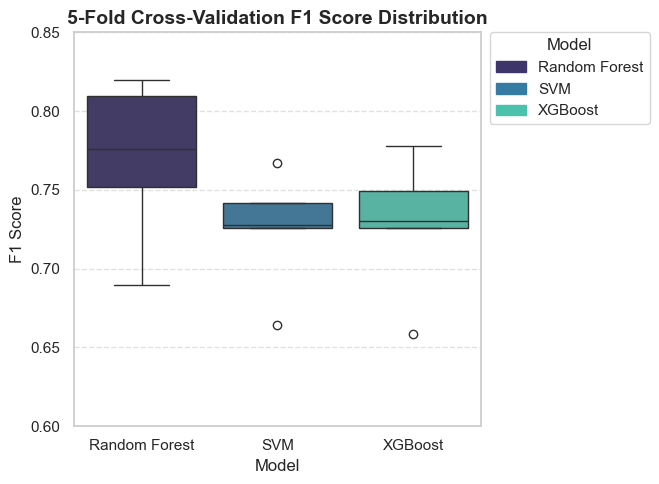

In [46]:
plot_cv_f1_scores(cv_df)

**Results Summary:**

Mean F1 Scores (Higher is better):

- Random Forest: 0.7694 — Best performer overall

- XGBoost: 0.7283

- SVM: 0.7253

Standard Deviation of F1 Scores (Lower is better):

- SVM: 0.0380 — Most consistent across folds

- XGBoost: 0.0440

- Random Forest: 0.0521


**Interpretation:**

Random Forest achieved the highest average F1 score, indicating the strongest overall predictive performance. SVM delivered the most consistent results across folds, while XGBoost offered a solid balance between accuracy and stability.

**Best Model:**

Random Forest emerged as the top-performing model based on overall evaluation:

Highest mean F1-score across 5-fold cross-validation: 0.769

Strong test set accuracy: 0.71

Best balance of precision and recall after tuning

Demonstrated robust performance even with some variability across folds

While SVM and XGBoost offered valuable alternatives, Random Forest consistently delivered the best predictive results for identifying customers likely to purchase travel insurance.









## Machine Learning Models: Model Ansembling (Voting Classifier)

### Model Ansembling

Converting Yes/No binary columns to 1/0:

In [36]:
binary_columns = ["GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad"]

df[binary_columns] = (
    df[binary_columns].replace({"Yes": 1, "No": 0}).infer_objects(copy=False)
)

In [37]:
accuracy, report = evaluate_voting_classifier(
    X_train_resampled, y_train_resampled, X_test_processed, y_test
)

Accuracy: 0.7864321608040201

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.91      0.85       256
           1       0.77      0.57      0.66       142

    accuracy                           0.79       398
   macro avg       0.78      0.74      0.75       398
weighted avg       0.78      0.79      0.78       398



**Results Summary:**

- Accuracy: 0.79

Class 1 (Purchased Insurance):

- Precision: 0.77

- Recall: 0.57

- F1-score: 0.66

Class 0 (Did Not Purchase):

- Precision: 0.79

- Recall: 0.91

- F1-score: 0.85

**Interpretation:**

- The model demonstrates solid overall accuracy (78.6%) and strong performance in predicting customers who did not purchase insurance (Class 0).

- Performance for identifying those who did purchase (Class 1) has improved, especially in recall (0.57 vs 0.43 previously) and F1-score (0.66 vs 0.54), indicating a better balance between precision and recall.

In [38]:
mean_f1, fold_scores = cross_validate_voting_classifier(
    X_train_resampled, y_train_resampled
)

F1 scores per fold: [0.7311828  0.71223022 0.72463768 0.76752768 0.75      ]
Mean F1 score: 0.7371


### Cross-Validating Assembly Model and F1 Comparison

**Purpose:** to compare the ensemble model's performance against individual base models (Random Forest, SVM, XGBoost) using 5-fold cross-validation.

In [ ]:
SVM_f1 = [0.767025, 0.741818, 0.664062, 0.725926, 0.727915]
rf_f1 = [0.775801, 0.751825, 0.689922, 0.809524, 0.820000]
xgb_f1 = [0.777778, 0.749064, 0.658730, 0.730038, 0.725926]
ensemble_f1 = [0.7311828, 0.71223022, 0.72463768, 0.76752768, 0.75]

cv_df = pd.DataFrame(
    {
        "Random Forest": rf_f1,
        "SVM": SVM_f1,
        "XGBoost": xgb_f1,
        "Ensemble Model": ensemble_f1,
    }
)

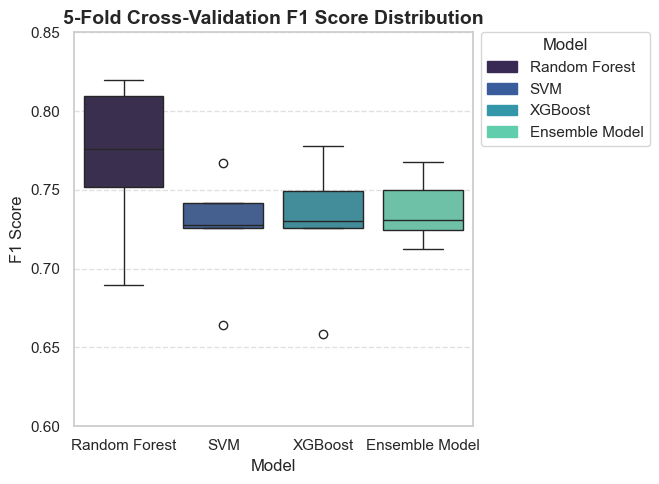

In [48]:
plot_cv_f1_scores(cv_df)

**Results Summary:** 

- Random Forest had the highest average F1 score and reached the top single-fold score, indicating the best predictive performance overall.

- Ensemble Model and XGBoost showed similar consistency, with F1 scores tightly clustered and slightly higher than SVM.

- SVM had the lowest median F1 score and more variability, suggesting less reliable performance across different folds.

### Tuning Voting Weights

**Purpose:** to optimize the contribution of each base model (Random Forest, SVM, XGBoost) within the ensemble by adjusting their voting weights.

In [41]:
evaluate_weighted_ensemble_pipeline(df)

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.87       256
           1       0.88      0.56      0.68       142

    accuracy                           0.81       398
   macro avg       0.84      0.76      0.77       398
weighted avg       0.82      0.81      0.80       398



(VotingClassifier(estimators=[('rf',
                               RandomForestClassifier(max_depth=10,
                                                      min_samples_split=10,
                                                      n_estimators=200,
                                                      random_state=42)),
                              ('svm',
                               SVC(C=1, probability=True, random_state=42)),
                              ('xgb',
                               XGBClassifier(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None, device=None,
                                             early_stopping_rounds=None,
                                             en...
                                          

**Results Summary:** 

| Metric                  | Before Tuning | After Tuning (Weighted Voting) |
| ----------------------- | ------------- | ------------------------------ |
| **Accuracy**            | 0.728         | 0.81                           |
| **Precision (Class 1)** | 0.68          | 0.88                           |
| **Recall (Class 1)**    | 0.56          | 0.56                           |
| **F1 Score (Class 1)**  | 0.61          | 0.68                           |
| **Recall (Class 0)**    | 0.84          | 0.96                           |
| **F1 Score (Class 0)**  | 0.79          | 0.87                           |
| **Voting Weights**      | `1, 1, 1`     | `1, 1, 2`                      |


**Interpretation:** 

Tuning the ensemble’s weights improved overall accuracy and boosted precision for Class 1, allowing the model to make more confident positive predictions. However, recall for Class 1 remained the same, meaning the model still misses some actual buyers. This trade-off leans toward fewer false positives, which can be preferable in cost-sensitive scenarios like insurance underwriting.

### Treshold Tuning

**Purpose:** if my model has high precision but low recall, it likely makes very conservative class 1 predictions.

Lowering the threshold (e.g. from 0.5 to 0.4 or 0.3) can increase recall by classifying more borderline cases as class 1 — possibly improving F1-score.

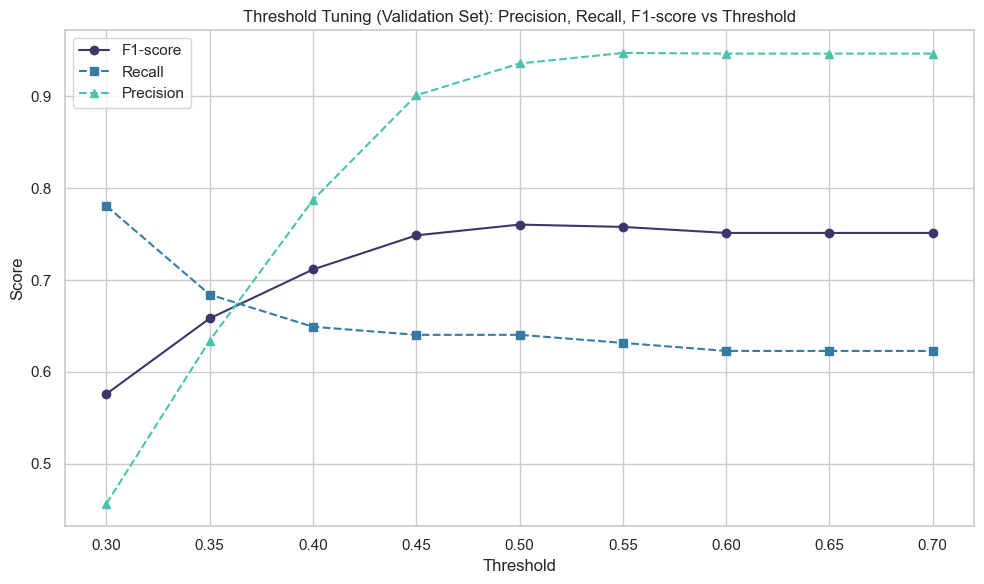

(VotingClassifier(estimators=[('rf',
                               RandomForestClassifier(max_depth=10,
                                                      min_samples_split=10,
                                                      n_estimators=200,
                                                      random_state=42)),
                              ('svm', SVC(C=1, probability=True)),
                              ('xgb',
                               XGBClassifier(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None, device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical...
                                             feature_weights=None, gamma=N

In [42]:
tune_threshold_on_validation_set(
    X_train_resampled, y_train_resampled, X_val_processed, y_val
)

**Interpretation:**

- The F1-score peaks around a threshold of 0.50, indicating the best balance between precision and recall.

- As the threshold increases, the model becomes more conservative in predicting the positive class:

- Precision improves — the model is more selective, reducing false positives.

- Recall declines — fewer actual buyers are identified, as the model predicts fewer positives overall.

### Confusion Matrix

**Purpose:** it will help understand how well classifier is doing by comparing actual vs. predicted values in a structured format.

In [50]:
threshold, accuracy = evaluate_ensemble_with_threshold(
    "TravelInsurancePrediction.csv", threshold=0.5
)

Confusion Matrix:
 [[241  15]
 [ 61  81]]

Classification Report (Threshold = 0.5):
               precision    recall  f1-score   support

           0       0.80      0.94      0.86       256
           1       0.84      0.57      0.68       142

    accuracy                           0.81       398
   macro avg       0.82      0.76      0.77       398
weighted avg       0.81      0.81      0.80       398



Plotting multiple confusion matrix heatmaps:

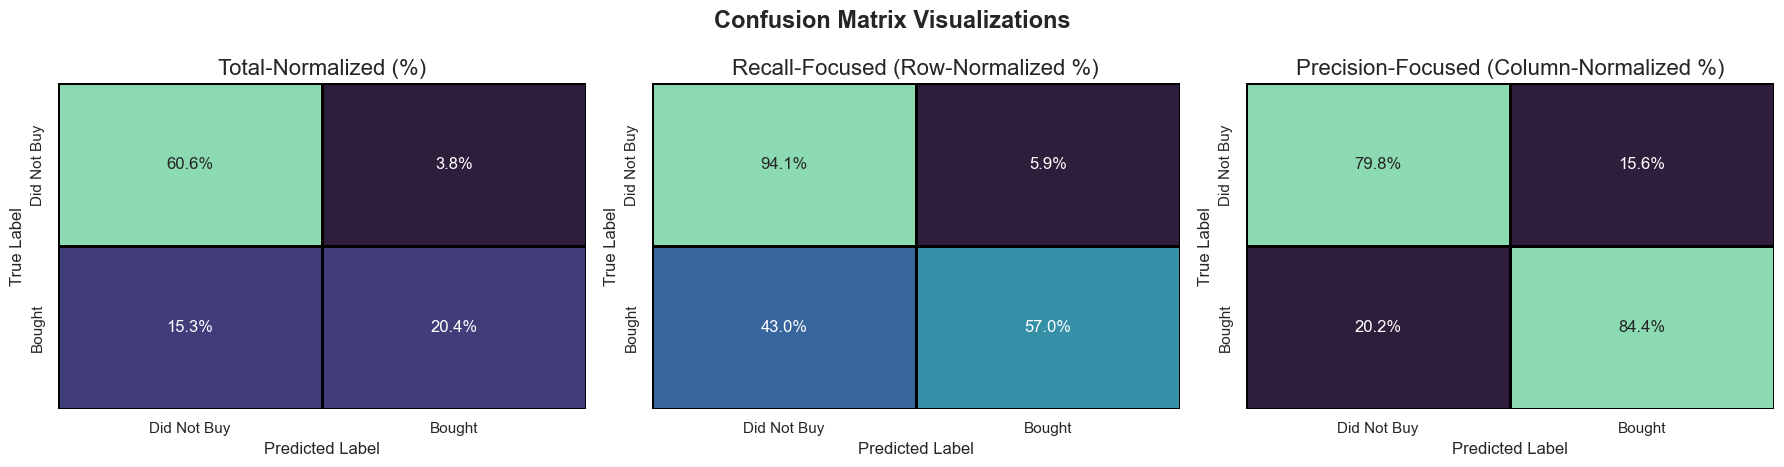

In [51]:
cm = np.array([[241, 15], [61, 81]])
labels = ["Did Not Buy", "Bought"]
visualize_confusion_matrix_variants(cm, labels)

**Results Summarry:** 

1. Overall Performance (Total-Normalized):

- True Negatives (Did Not Buy predicted correctly): 60.6%

- True Positives (Bought predicted correctly): 20.4%

- False Negatives: 15.3%

- False Positives: 3.8%

2. Recall-Focused View (Row-Normalized):

- Class 0 Recall: 94.1% of non-buyers were correctly identified.

- Class 1 Recall: 57.0% of actual buyers were correctly identified.

3. Precision-Focused View (Column-Normalized):

- Class 0 Precision: 79.8% of those predicted not to buy truly didn’t.

- Class 1 Precision: 84.4% of those predicted to buy actually did — indicating very strong precision.

**Interpretation:** 

At a threshold of 0.50, the ensemble model delivers balanced performance with high precision for buyers (84.4%), moderate recall (57.0%), and strong accuracy in identifying non-buyers (94.1%), ensuring most predicted buyers truly purchased insurance.

## Comparing Final Voting Ensemble Model vs Best Base Model (Random Forest)

**Purpose:** to compare the final Voting Ensemble model with the best-performing individual base model (Random Forest) in order to determine which approach provides better predictive performance for identifying customers likely to purchase travel insurance.

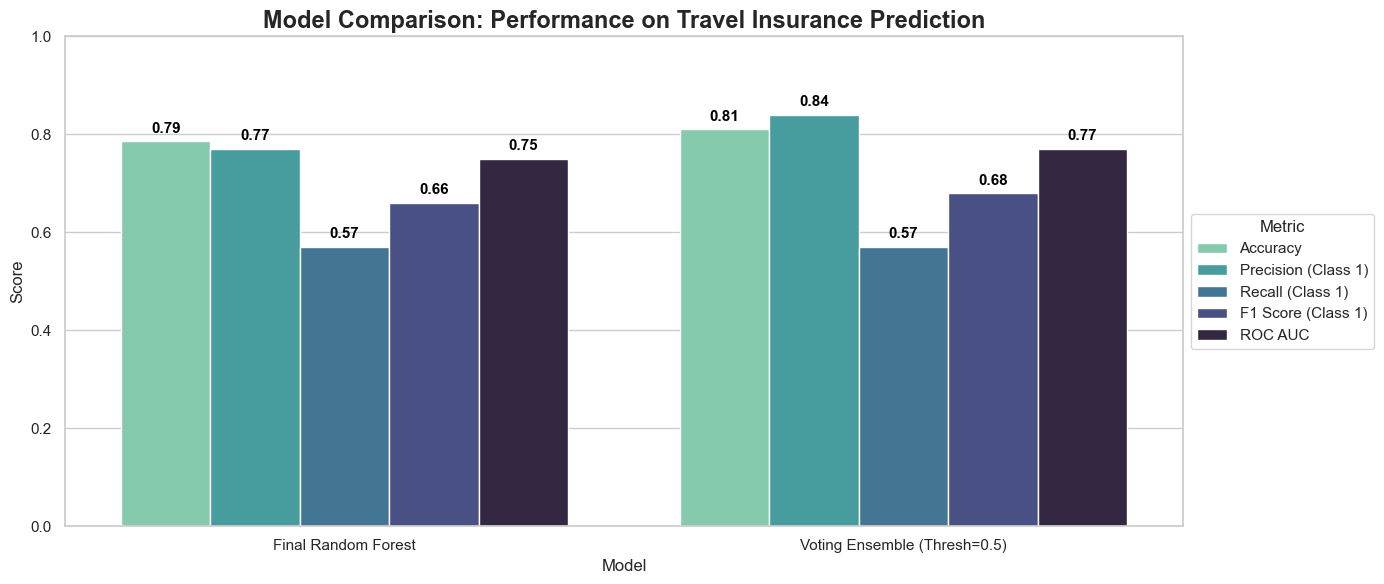

In [ ]:
metrics = {
    "Model": ["Final Random Forest", "Voting Ensemble (Thresh=0.5)"],
    "Accuracy": [0.786, 0.81],
    "Precision (Class 1)": [0.77, 0.84],
    "Recall (Class 1)": [0.57, 0.57],
    "F1 Score (Class 1)": [0.66, 0.68],
    "ROC AUC": [0.75, 0.77],
}

plot_vertical_model_comparison(metrics)

| Metric                  | Voting Ensemble (Thresh=0.50)                                    | Final Random Forest                   |
| ----------------------- | ---------------------------------------------------------------- | ------------------------------------- |
| **Accuracy**            | 0.81                                                             | 0.79                                  |
| **Precision (Class 1)** | 0.84                                                             | 0.77                                  |
| **Recall (Class 1)**    | 0.57                                                             | 0.57                                  |
| **F1 Score (Class 1)**  | 0.68                                                             | 0.66                                  |
| **Interpretation**      | Best overall performer with strong precision and balanced recall | Solid but slightly less precise model |




**Results Summary:** 

- The Voting Ensemble provides the highest precision (84%) and strong overall accuracy (81%), making it ideal for minimizing false positives and confidently identifying buyers.

- Random Forest delivers comparable recall and a slightly lower F1-score, offering a solid alternative when consistent buyer detection is needed.


**Best Model:** 

Voting Essemble Model.

The Voting Ensemble (with a 0.50 threshold) outperforms individual models in key test set metrics:

- Highest Precision (84%): It is the most reliable at correctly identifying actual buyers, reducing costly false positives.

- Best Accuracy (81%): Indicates strong overall predictive power across both classes.

- Balanced Recall (57%): Matches Random Forest in identifying actual buyers, but with greater confidence.

- Top F1 Score (0.68): Offers the best balance between precision and recall for the positive class (buyers).

- Highest ROC AUC (0.77): Confirms the ensemble’s superior ranking ability in distinguishing between buyers and non-buyers.


## Conclusions

Customers with the highest likelihood of purchasing travel insurance typically share the following characteristics:

- Frequent Flyers – Regular air travel indicates travel habits that benefit from insurance.

- Previously Traveled Abroad – Experience with international travel increases perceived need for coverage.

- Age 30+ – Older individuals usually prioritize security and risk management more.

- Higher Annual Income – Financial ability supports purchasing optional protection like insurance.



### Key Insights from EDA and Inference

1. Travel history plays a major role: people who have traveled abroad before are significantly more likely to buy travel insurance.

2. Higher income is also associated with a greater likelihood of purchasing insurance.

3. Graduates showed a slightly higher uptake, though the difference was not statistically significant.

4. The government sector employees were less likely to purchase insurance compared to those in the private or self-employed sector.


### Hypotheses Approval:

1. H1 **Supported** (People with experience abroad are more likely to buy insurance)

2. H2 **Supported** (Higher income individuals more likely buys insurance)

3. H3 **Not Supported** (Graduates more likely to buy insurance)

### Best Model

**The Voting Ensemble (with a 0.50 threshold)** outperformed individual models in key test set metrics: it had highest precision, accuracy, f1 score and same recal as best base model (Random Forest).

## Suggestions for Improvement



**Collect More Data**

The dataset is relatively small. More diverse and recent data could help models generalize better and reduce overfitting.

**Refine Feature Engineering**

Investigate new features (e.g., travel history, booking patterns).

Explore interactions between categorical and numerical variables.

Consider using target encoding or ordinal encoding if some categorical variables have an inherent order.

**Try Advanced Models**

Explore LightGBM or CatBoost, which often outperform traditional models on structured/tabular data.

Experiment with stacking (ensemble of ensembles) for marginal performance gains.

**Threshold Optimization**

Dive deeper into custom threshold tuning depending on whether you want to prioritize precision (avoiding false positives) or recall (catching more positives).

**Cross-Validation Improvements**

Use Stratified K-Fold CV to maintain class balance across folds.

Consider nested cross-validation when hyperparameter tuning and evaluating model performance simultaneously.

**Handle Class Imbalance More Effectively**

Test other resampling methods beyond SMOTE (e.g., SMOTE-ENN, ADASYN).

Use class weights in models where applicable.

**Model Interpretability**

Apply SHAP or LIME to interpret predictions and increase trust in the model, especially useful in business settings.